In [7]:
#include "TH1.h"
#include "TF1.h"
#include "TString.h"
#include "TFile.h"
#include "TCanvas.h"
#include "TLatex.h"
#include "TMath.h"
#include <TStyle.h>
#include <TGaxis.h>
#include <iostream>
#include <fstream>

In [8]:
double fitFunc(double *x, double *par)
{
    // par[0] background level
    // par[1] number of muons
    // par[2] muon lifetime
    return par[1] * (TMath::Exp(-x[0] / par[2])) + par[0];
}

In [9]:
double fitFunc2(double *x, double *par) {
    // par[0] background
    // par[1] number of positive muons
    // par[2] muon lifetime
    // par[3] muon capture lifetime
    // par[4] fraction of positive to negative muons Nmu+/Nmu-
    return par[1] * (TMath::Exp(-x[0]/par[2])) * (TMath::Exp(-x[0]/par[3])/par[4] + 1.0) + par[0];
}

In [10]:
double fitFunc3(double *x, double *par) {
    // par[0] background
    // par[1] number of positive muons
    // par[2] muon lifetime
    // par[3] muon capture lifetime
    // par[4] fraction of positive to negative muons Nmu+/Nmu-
    return par[1] * (TMath::Exp(-x[0]/par[2])) * (TMath::Exp(-x[0]/par[3])/par[4] + 1.0) + par[6]*TMath::Exp(-x[0]/par[5])+par[0];
    //(TMath::Exp(-x[0]/par[3])/par[4] + 1.0) + par[6]*x[0]*x[0]+par[5]*x[0]+par[0];
}

In [11]:
Bool_t loadFromFile=kFALSE;
//Numbers on the axis times 10^(x*3), where x is an integer
   TGaxis::SetMaxDigits(3);

   const int NFITMETHODS=3;
   const int SIMPLE=0;
   const int SOPHISTICATED=1;
   const int TEST=2;

	string fileStrings[NFITMETHODS] = {"Exponential","TwoExponentials","ThreeExponentials"};
   // ********CHOOSE FITFUNCTION*********** SOPHISTICATED = two exponentials including the myon capture, SIMPLE = one exponential *******//
	int usefunction = SOPHISTICATED;
	// int usefunction = SIMPLE;
	//int usefunction = TEST;



//   gROOT->Macro("./init_talk.C");

   bool debugout=false; //set true to enable output of numbers

   //Number of Detectors used - program breaks if wrong
   const int nDet =8;
   //Maximum Number of Entries per Detector
   const int nTimeWindows =2;

   //TimeWindow for Muon:
   //i.e.: Starttime windows in ns
   const double muontimelow = -250.;
   const double muontimehigh = -1.;


   //____________________________
   // ******SET FITRANGES***** //

//   const int FitLowX=500;
   // const int FitLowX=200;
   // const int FitLowX=550;
   // const int FitLowX=600;
   // const int FitLowX=500;
   //const int FitLowX=4000;
    const int FitLowX=1000;

    // const int FitHighX=5000;
   // const int FitHighX=4250;
   const int FitHighX=4500;
   //const int FitHighX=10000;
   //____________________________




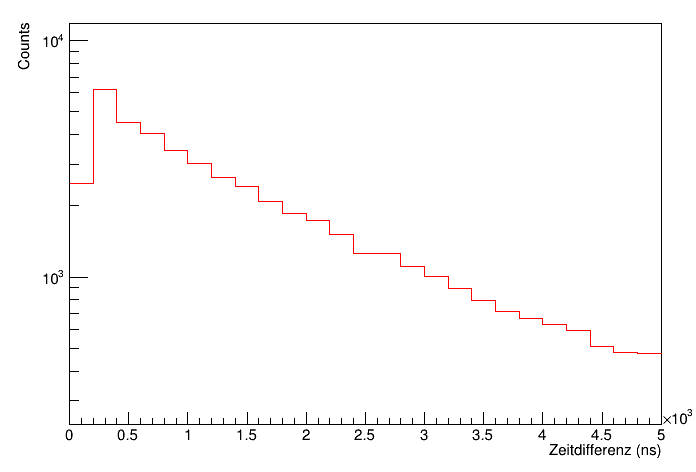

Lines read: 46727


Warning in <TROOT::Append>: Replacing existing TH1: hTimeDistribution (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cTimeDist


In [12]:
  TH1F* hTimeDistribution=0x0;
	 if (!loadFromFile) {
	  ifstream inFile;

   // ***** READ DATA FILE ******* //
  // inFile.open("Myonen_2019_05_27,12h00m52s.txt");
 //  inFile.open("Myonen_2014_04_28,12h52m26s.txt");
         inFile.open("Myonen_2024_01_22_12h07m15s.txt");


   double Timestamp;
   double HitTimes[nTimeWindows][nDet];
   double HitCount[nDet];

   //Initialize Histogram for time delay information
   hTimeDistribution = new TH1F("hTimeDistribution","hTimeDistribution",50,0.,5000.);
   hTimeDistribution->GetXaxis()->SetTitle("Zeitdifferenz (ns)");
   hTimeDistribution->GetYaxis()->SetTitle("Counts");




   //Read data from file
   int linesread=0;
   while (!inFile.eof()) {
	  inFile >> Timestamp;
	  for (int i=0; i < nTimeWindows; i++) {
		 for (int j=0; j < nDet; j++) {
			inFile >> HitTimes[i][j];
		 }
	  }
	  for (int j=0; j < nDet; j++) {
		 inFile >> HitCount[j];
	  }

	  linesread++;


	  //Control output for debugging, part 1
	  if (debugout) {
		 for (int detno=0; detno < nDet; detno++) {
			//Only executed if Hitcount[detno] > 0
			for (int hitno=0; hitno < HitCount[detno]; hitno++) {
			   //cout << HitTimes[hitno][detno] << " "  ;
			}
		 }
		 //cout << endl;
	  }


	  //Get average time of incoming muon - t0:
	  double timesum=0.;
	  int timestoaverage=0;

	  for (int detno=0; detno < nDet; detno++) {
		 //Only executed if Hitcount[detno] > 0
		 for (int hitno=0; hitno < HitCount[detno]; hitno++) {
			if ((HitTimes[hitno][detno] >= muontimelow) &&
				  (HitTimes[hitno][detno] <= muontimehigh)) {
			   timestoaverage++;
			   timesum+=HitTimes[hitno][detno];
			}
		 }
	  }
	  //Now get average:
	 // cout << "ts: " << timesum << " tta: " << timestoaverage << endl;
	  if (timestoaverage ==0) break;
	  double t0 = timesum/timestoaverage;

	  double lowestlatesthit=-10000.;
	  //Only take clean events with exactly one delayed hit
	  //Introduce counter to crosscheck
	  int NumberOfDelayedHitsInEvent=0;
	  for (int detno=0; detno < nDet; detno++) {
		 //Only executed if Hitcount[detno] > 0
		 for (int hitno=0; hitno < HitCount[detno]; hitno++) {
			//is hit delayed?
			if (HitTimes[hitno][detno] > muontimehigh) {
			   //if so, is this hit in in the last layer hit by muon or in
			   //the one after that AND is the hit the later one if there are two?
			   if ((HitTimes[hitno][detno] >lowestlatesthit) && (
						// ******Take SAME AND LOWER Layer***** //
						(detno==timestoaverage)|| (detno==timestoaverage-1)))
						// ******Take ONLY Lower Layer****** //
			    //   (detno==timestoaverage)))
			   {
				  lowestlatesthit=HitTimes[hitno][detno];
				  NumberOfDelayedHitsInEvent++;
			   }
			}
		 }
	  }
	  if (NumberOfDelayedHitsInEvent !=1) {
		 //cout << "aborting event: " << NumberOfDelayedHitsInEvent << " delayed hits found in line " << linesread << "." <<  endl;
		 continue;
	  }

	  //Calculate time delay
	  double DeltaT= lowestlatesthit-t0;
	  //Fill in histogram
	  hTimeDistribution->Fill(DeltaT);

	  if (debugout) {
		 //second part of debug output
		 cout << "avg starttime: " << t0 ;
		 cout << " Lowest latest hit: " << lowestlatesthit  ;
		 cout << " DeltaT: " << DeltaT << endl;
	  }


   }
   cout << "Lines read: " << linesread << endl;

   TFile* fOut = new TFile("myonlifetime.root","RECREATE");
   hTimeDistribution->Write();
   fOut->Close();
   }
  else {

	TFile* fHistoIn= new TFile("myonlifetime.root");

	hTimeDistribution = (TH1F*) fHistoIn->Get("hTimeDistribution");
  }

   // ******REBIN THE HISTOGRAMM ******//
   hTimeDistribution->Rebin(2);
   //Create new canvas and plot histogram
   TCanvas* cTimeDist = new TCanvas("cTimeDist","cTimeDist");
   cTimeDist->SetTopMargin(0.05);
   cTimeDist->SetRightMargin(0.05);
   //Deactivates the stat box of histograms
   gStyle->SetOptStat(kFALSE);
   cTimeDist->SetLogy();
   hTimeDistribution->SetTitle("");
   hTimeDistribution->SetLineColor(kRed);
   hTimeDistribution->SetMarkerColor(kRed);
   hTimeDistribution->Draw();
   cTimeDist->Update();


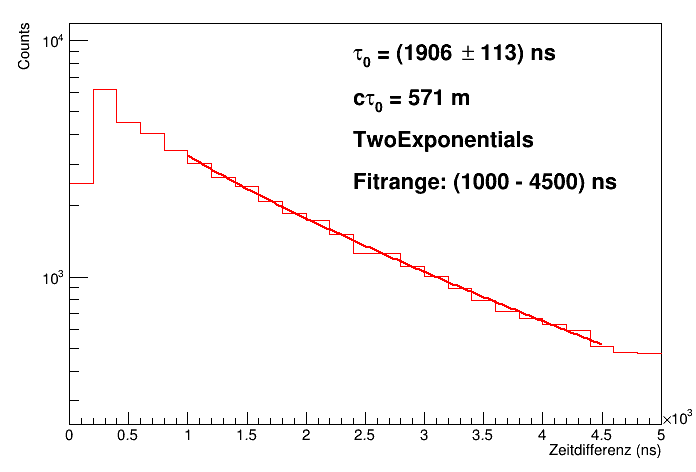

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      16.6298
NDf                       =           13
Edm                       =  1.02193e-05
NCalls                    =          306
BG                        =      82.2624   +/-   77.9269      	 (limited)
# #mu^{+}                 =      4597.78   +/-   386.661      	 (limited)
#tau_{0}                  =      1906.21   +/-   112.808      	 (limited)
#tau_{c}                  =      745.657   +/-   253.113      	 (limited)
# #mu^{+}/# #mu^{-}       =          1.6   +/-   0.496268     	 (limited)


Info in <TCanvas::Print>: pdf file MyonlifetimeFitTwoExponentials_1000to4500.pdf has been created


In [13]:
  



   double measuredlifetime=0.;
   double lifetimeerror=0.;

   if (usefunction==SIMPLE) {
	  //Simple exponential + Background as FitFunction
	  TF1* fFitFunc = new TF1("fFitFunc",fitFunc,FitLowX,FitHighX,3);
	  fFitFunc->SetParameters(20.,1.,2000.);
	  //fFitFunc->FixParameter(2,2100.);
	  hTimeDistribution->Fit(fFitFunc,"R");
	  measuredlifetime= fFitFunc->GetParameter(2);
      lifetimeerror=fFitFunc->GetParError(2);
   }
   else if (usefunction==SOPHISTICATED) {
	  // More sophisticated Fit Function with Defaults from Heidelberg
	  TF1* fFitFunc2 = new TF1("fFitFunc",fitFunc2,FitLowX,FitHighX,5);
	  fFitFunc2->SetParName(0, "BG");
	  fFitFunc2->SetParName(1, "# #mu^{+}");
	  fFitFunc2->SetParName(2, "#tau_{0}");
	  fFitFunc2->SetParName(3, "#tau_{c}");
	  fFitFunc2->SetParName(4, "# #mu^{+}/# #mu^{-}");
	  // Funktion mit 200 Punkten zeichnen
	  fFitFunc2->SetNpx(200);
	  // Grenzen fuer die Parameter setzen
	  fFitFunc2->SetParLimits(0, 1e-5, 1e2);
	  fFitFunc2->SetParLimits(1, 0., 1000000.);
	  fFitFunc2->SetParLimits(2, 1700., 2700.);
	  fFitFunc2->SetParLimits(3, 100., 1500.);
	  //fFitFunc2->SetParLimits(4, 0.05, 20.);
	  fFitFunc2->SetParLimits(4, 1.00, 1.6);
	  // Startwerte fuer Parameter setzen
	  fFitFunc2->SetParameters(10., 5000., 2500., 800., 1.4);
	  // Verhaeltnis von pos. zu neg. Myonen festsetzen (oder auch nicht!)
	  //fFitFunc2->FixParameter(4, 1.3);
	  // Farbe setzen
	  fFitFunc2->SetLineColor(kRed);
	  hTimeDistribution->Fit(fFitFunc2,"R");
	  measuredlifetime=fFitFunc2->GetParameter(2);
      lifetimeerror=fFitFunc2->GetParError(2);
   }
   else if (usefunction==TEST) {
	  // More sophisticated Fit Function with Defaults from Heidelberg
	  TF1* fFitFunc3 = new TF1("fFitFunc3",fitFunc3,FitLowX,FitHighX,7);
	  fFitFunc3->SetParName(0, "BG");
	  fFitFunc3->SetParName(1, "# #mu^{+}");
	  fFitFunc3->SetParName(2, "#tau_{0}");
	  fFitFunc3->SetParName(3, "#tau_{c}");
	  fFitFunc3->SetParName(4, "# #mu^{+}/# #mu^{-}");
	  fFitFunc3->SetParName(5, "# additional exp");
	  fFitFunc3->SetParName(6, "# additional const");
	  // Funktion mit 200 Punkten zeichnen
	  fFitFunc3->SetNpx(200);
	  // Grenzen fuer die Parameter setzen
	  fFitFunc3->SetParLimits(0, 1e-5, 1e2);
	  fFitFunc3->SetParLimits(1, 0., 1000000.);
	  fFitFunc3->SetParLimits(2, 1700., 2700.);
	  fFitFunc3->SetParLimits(3, 100., 1500.);
	  fFitFunc3->SetParLimits(4, 0.05, 20.);
	  // Startwerte fuer Parameter setzen
	  fFitFunc3->SetParameters(10., 5000., 2500., 800., 1.4,10.,5000.);
	  // Verhaeltnis von pos. zu neg. Myonen festsetzen (oder auch nicht!)
	  fFitFunc3->FixParameter(4, 1.3);
	  // Farbe setzen
	  fFitFunc3->SetLineColor(kRed);
	  hTimeDistribution->Fit(fFitFunc3,"R");
	  measuredlifetime=fFitFunc3->GetParameter(2);
   }
   char cLifeTime[256];
     sprintf(cLifeTime,"#tau_{0} = %.0f ns",measuredlifetime);


   cTimeDist->Update();
   TLatex lLifeTime;
   //Get the Maximum y coordinate in the canvas to draw all inforamtion at relative hight
   double yLifeTime = pow(10, gPad->GetUymax());
   //Draw Lifetime
     lLifeTime.DrawLatex(2400, yLifeTime*0.7, Form("#tau_{0} = (%.0f #pm %.0f) ns", measuredlifetime, lifetimeerror));
   //Draw c tau
   lLifeTime.DrawLatex(2400, yLifeTime*0.45, Form("c#tau_{0} = %.0f m", measuredlifetime*pow(10., -9.)*TMath::C()));
   //Draw the used function
   lLifeTime.DrawLatex(2400, yLifeTime*0.3, fileStrings[usefunction].c_str());
   //Draw the used fitrange
   lLifeTime.DrawLatex(2400, yLifeTime*0.2, Form("Fitrange: (%d - %d) ns", FitLowX, FitHighX));


   char outFileName[256];
   //Save Plot as file with all information needed. Only the information for the
   //layer which are allowed for the electron singal needs to be changed by hand
   //and the rebinning
   sprintf(outFileName,"MyonlifetimeFit%s_%dto%d.pdf",fileStrings[usefunction].c_str(), FitLowX, FitHighX);
   cTimeDist->SaveAs(outFileName);